In [13]:
setwd('/import/liujing/data/my')

In [14]:
load('../combat_edata1.rda')

In [15]:
library(dplyr)

In [16]:
expr = combat_edata1 %>%  t() %>%  as.data.frame()  

In [17]:
bulk3.group = read.csv('bulk.3.group.csv',row.names = 1)

In [18]:
expr1 = expr[rownames(bulk3.group),] %>% t() %>%  as.data.frame()

In [19]:
dim(expr1)

[1] 28056    59

In [20]:
group.all1 = bulk3.group

In [21]:
dataExpr = expr1

In [22]:
library(WGCNA)
library(reshape2)
library(stringr)
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()
#exprMat <- "./fpkm.txt"
type = "unsigned"
corType = "pearson"
corFnc = ifelse(corType=="pearson", cor, bicor)
maxPOutliers = ifelse(corType=="pearson",1,0.05)
robustY = ifelse(corType=="pearson",T,F)

Allowing parallel execution with up to 255 working processes.


In [23]:
m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.25))[2],0.05)),]

dataExpr <- as.data.frame(t(dataExprVar))
gsg = goodSamplesGenes(dataExpr, verbose = 3)

 Flagging genes and samples with too many missing values...
  ..step 1


In [24]:
dim(dataExpr)

[1]    59 18431

In [25]:
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}


In [26]:
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
dim(dataExpr)

[1]    59 18431

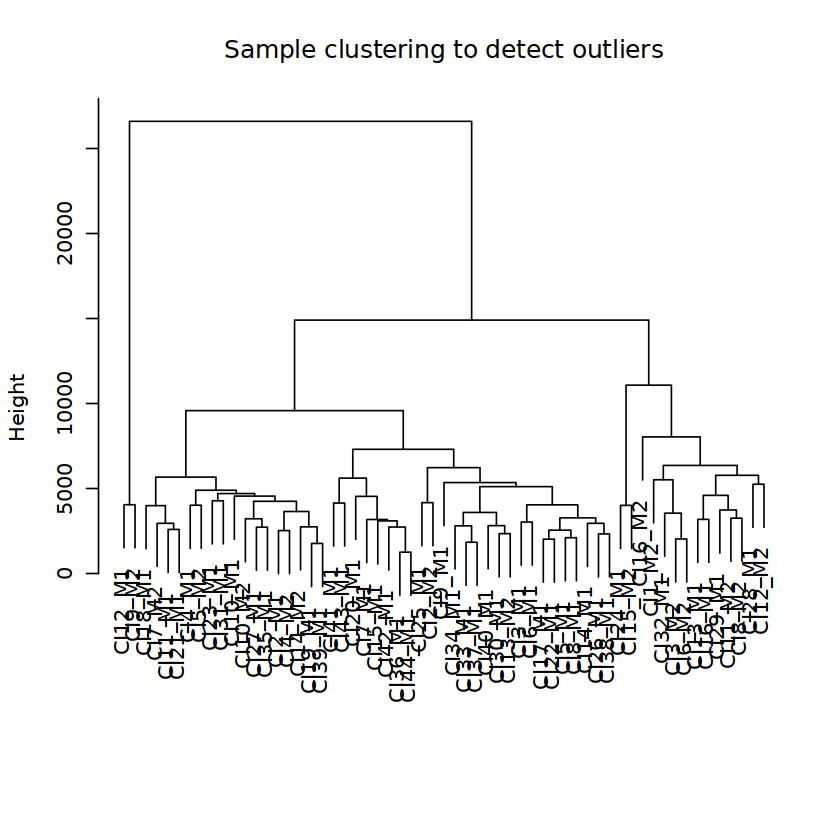

In [27]:
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

In [ ]:
powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

pickSoftThreshold: will use block size 2427.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2427 of 18431


In [ ]:
options(repr.plot.width = 9)

In [ ]:
par(mfrow = c(1,2))
cex1 = 0.8
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.8,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [ ]:
power = sft$powerEstimate
power

In [ ]:
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}

In [ ]:
exprMat='data.txt'

In [ ]:
net = blockwiseModules(dataExpr, power = power, maxBlockSize = nGenes,
                       TOMType = type, minModuleSize = 50,
                       reassignThreshold = 0, mergeCutHeight = 0.5,  # 模块太多修改这个
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs=TRUE, corType = corType, 
                       maxPOutliers=maxPOutliers, loadTOMs=TRUE,
                       saveTOMFileBase = paste0(exprMat, ".tom"),
                       verbose = 3)

In [ ]:
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [ ]:
MEs = net$MEs
MEs_col = MEs
colnames(MEs_col) = paste0("ME", labels2colors(
  as.numeric(str_replace_all(colnames(MEs),"ME",""))))
MEs_col = orderMEs(MEs_col)

In [ ]:
plotEigengeneNetworks(MEs_col, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)

In [ ]:
TOM = TOMsimilarityFromExpr(dataExpr, power=power, corType=corType, networkType=type)

In [ ]:
group.all1  = group.all1 %>%  tibble::rownames_to_column(.,'sample')

In [ ]:
group.all1$group = as.character(group.all1$group )

In [ ]:
design <- model.matrix(~0 + group.all1$group)


In [ ]:
dimnames(design) <- list(group.all1$sample, sort(unique(group.all1$group)))


In [ ]:

design <- design[rownames(MEs_col),]
# 计算 pearson 相关性和显著性
modTraitCor <- cor(MEs_col, design, use = "p")
modTraitP <- corPvalueStudent(modTraitCor, dim(group.all1)[1])

In [ ]:
modTraitCorP = bicorAndPvalue(MEs_col, design)
modTraitCor = modTraitCorP$bicor
modTraitP   = modTraitCorP$p

In [ ]:
textMatrix <- paste0(signif(modTraitCor, 2), "\n(", signif(modTraitP, 1), ")")
dim(textMatrix) <- dim(modTraitCor)
labeledHeatmap(
  Matrix = modTraitCor,
  xLabels = colnames(design),
  yLabels = colnames(MEs_col),
  cex.lab = 0.5,
  ySymbols = colnames(MEs_col),
  colorLabels = FALSE,
  colors = blueWhiteRed(50),
  textMatrix = textMatrix,
  setStdMargins = FALSE,
  cex.text = 0.5,
  zlim = c(-1, 1),
  main = paste("Module-trait relationships")
)

In [ ]:
dat = dataExpr

In [ ]:
nSamples <- nrow(dat)
#计算MM值和GS值
modNames <- substring(colnames(MEs_col), 3) ##切割，从第三个字符开始保存
geneModuleMembership <- as.data.frame(cor(dat, MEs, use = "p")) #算出每个模块跟基因的Pearson相关系数矩阵
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples)) #计算MM值对应的P值
names(geneModuleMembership) <- paste("MM", modNames, sep="")
names(MMPvalue) <- paste("p.MM", modNames, sep="")
geneTraitSignificance <- as.data.frame(cor(dat, design, use = "p")) 

In [ ]:
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))
names(geneTraitSignificance) <- paste("GS.", colnames(design), sep="")
names(GSPvalue) <- paste("p.GS.", colnames(design), sep="")

In [36]:
module <- "yellow"
column <- match(module, modNames)  ##在所有模块中匹配选择的模块，返回所在的位置
brown_moduleGenes <- names(net$colors)[which(moduleColors == module)]
MM <- abs(geneModuleMembership[brown_moduleGenes, column])
GS <- abs(geneTraitSignificance[brown_moduleGenes, 1])

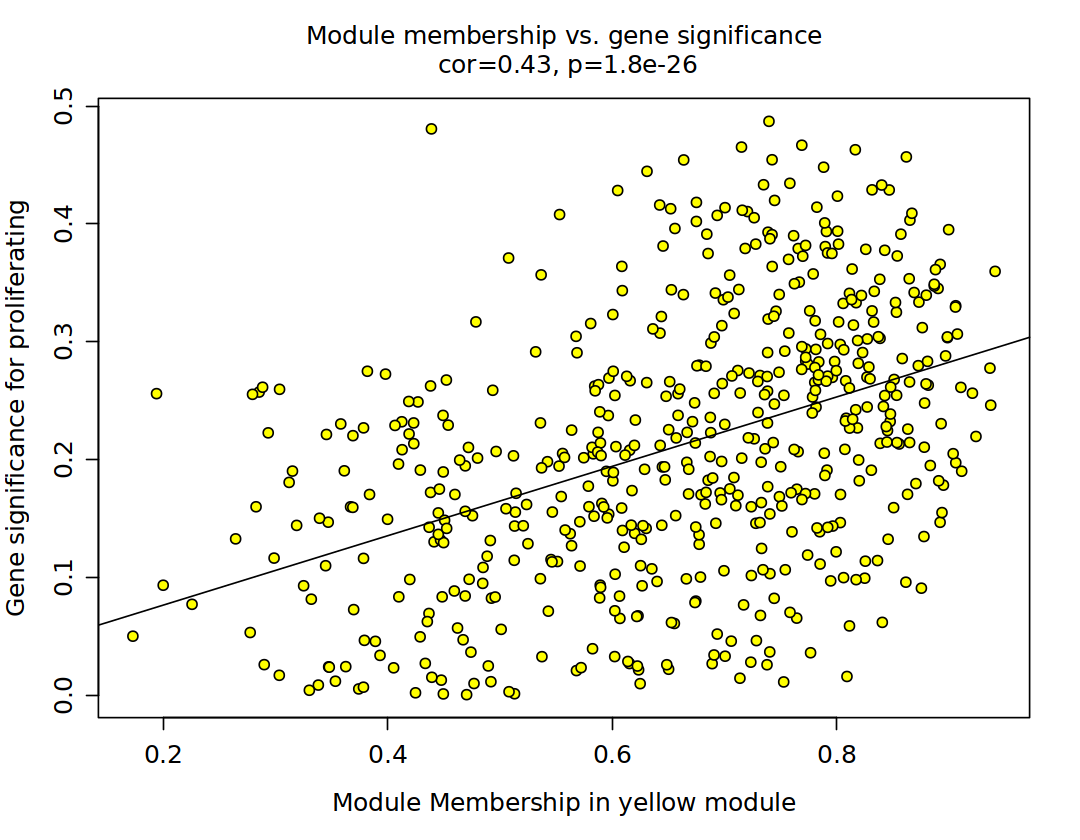

In [37]:
verboseScatterplot(
  MM, GS,
  xlab = paste("Module Membership in", module, "module"),
  ylab = "Gene significance for proliferating",
  main = paste("Module membership vs. gene significance\n"),
  abline = TRUE,
  pch = 21,
  cex.main = 1.2,
  cex.lab = 1.2,
  cex.axis = 1.2,
  col = "black",
  bg = module
)

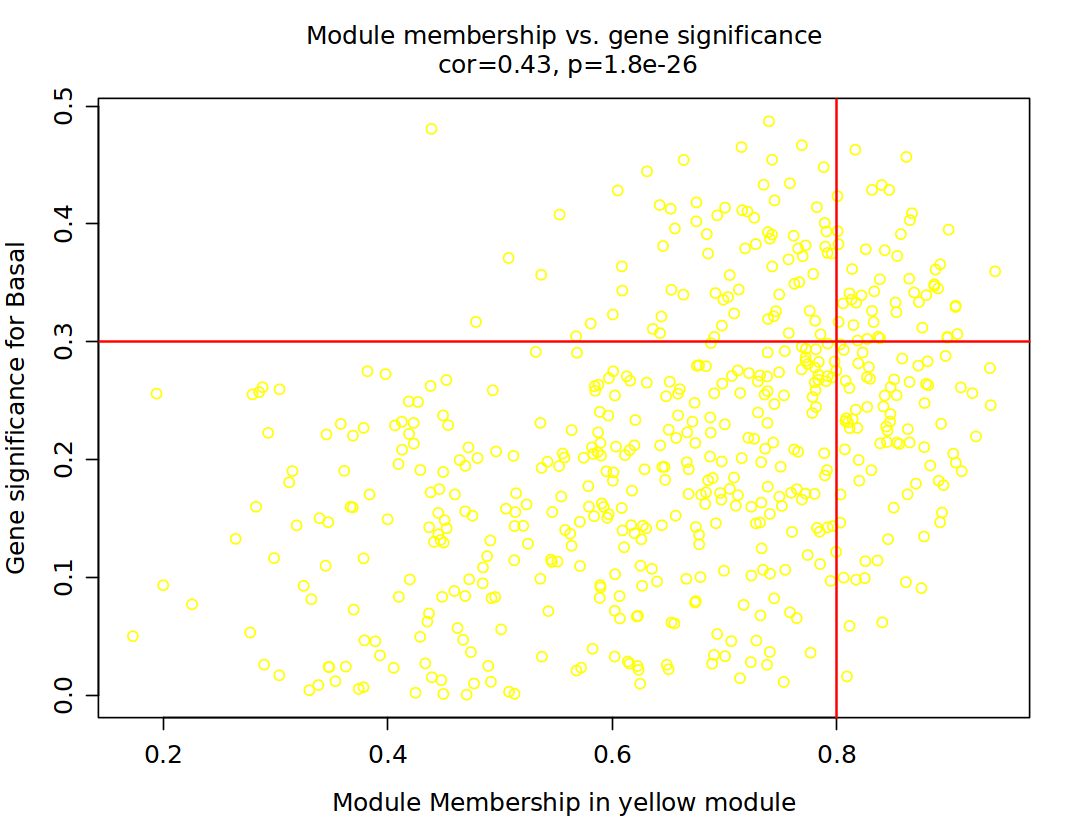

In [38]:
verboseScatterplot(MM, GS,
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Basal",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
abline(h=0.3,v=0.8,col="red",lwd=1.5)

In [39]:
brown_hub <- brown_moduleGenes[(GS > 0.3 & MM > 0.8)]
length(brown_hub)

[1] 49

In [40]:
write.csv(brown_hub,'brown_hub_gene.csv')

In [41]:
library(clusterProfiler)
library(org.Hs.eg.db)
options(stringsAsFactors = F)
 
brown_hub_gene <- read.csv('brown_hub_gene.csv',header = F)
brown_hub_gene <- brown_hub_gene[-1,]
brown_hub_gene <- brown_hub_gene[,-1]
gene=unique(brown_hub_gene)
##基因转ID
sig_DP_entrezId <- mapIds(x = org.Hs.eg.db,
                             keys = gene,
                             keytype = "SYMBOL",
                             column = "ENTREZID")


Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfil

In [42]:
table(is.na(sig_DP_entrezId))


FALSE  TRUE 
   47     2 

In [43]:

sig_DP_entrezId <- na.omit(sig_DP_entrezId)
go_bp <- enrichGO(gene = sig_DP_entrezId,
                      OrgDb = org.Hs.eg.db,
                      keyType = "ENTREZID",
                      ont = "ALL",
                      pvalueCutoff = 0.05,
                      qvalueCutoff = 1,
                      readable = TRUE)


In [44]:
go_bp@result

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0006639,BP,GO:0006639,acylglycerol metabolic process,5/45,132/18903,1.502506e-05,9.311715e-03,7.480541e-03,ACSL1/DGAT2/PGS1/PLIN5/SLC22A4,5
GO:0006638,BP,GO:0006638,neutral lipid metabolic process,5/45,133/18903,1.558446e-05,9.311715e-03,7.480541e-03,ACSL1/DGAT2/PGS1/PLIN5/SLC22A4,5
GO:0006641,BP,GO:0006641,triglyceride metabolic process,4/45,104/18903,1.083055e-04,3.768624e-02,3.027514e-02,ACSL1/DGAT2/PLIN5/SLC22A4,4
GO:0019432,BP,GO:0019432,triglyceride biosynthetic process,3/45,41/18903,1.261464e-04,3.768624e-02,3.027514e-02,ACSL1/DGAT2/PLIN5,3
GO:0046460,BP,GO:0046460,neutral lipid biosynthetic process,3/45,49/18903,2.151409e-04,3.957061e-02,3.178894e-02,ACSL1/DGAT2/PLIN5,3
GO:0046463,BP,GO:0046463,acylglycerol biosynthetic process,3/45,49/18903,2.151409e-04,3.957061e-02,3.178894e-02,ACSL1/DGAT2/PLIN5,3
GO:0072593,BP,GO:0072593,reactive oxygen species metabolic process,5/45,235/18903,2.317944e-04,3.957061e-02,3.178894e-02,ALOX5/FPR2/NCF4/PLIN5/TLR4,5
GO:0101002,CC,GO:0101002,ficolin-1-rich granule,7/46,185/19869,2.132889e-07,1.636622e-05,1.344962e-05,ALOX5/FCAR/FPR1/FPR2/HSPA6/SLC11A1/SLC2A3,7
GO:0101003,CC,GO:0101003,ficolin-1-rich granule membrane,5/46,61/19869,2.871267e-07,1.636622e-05,1.344962e-05,FCAR/FPR1/FPR2/SLC11A1/SLC2A3,5


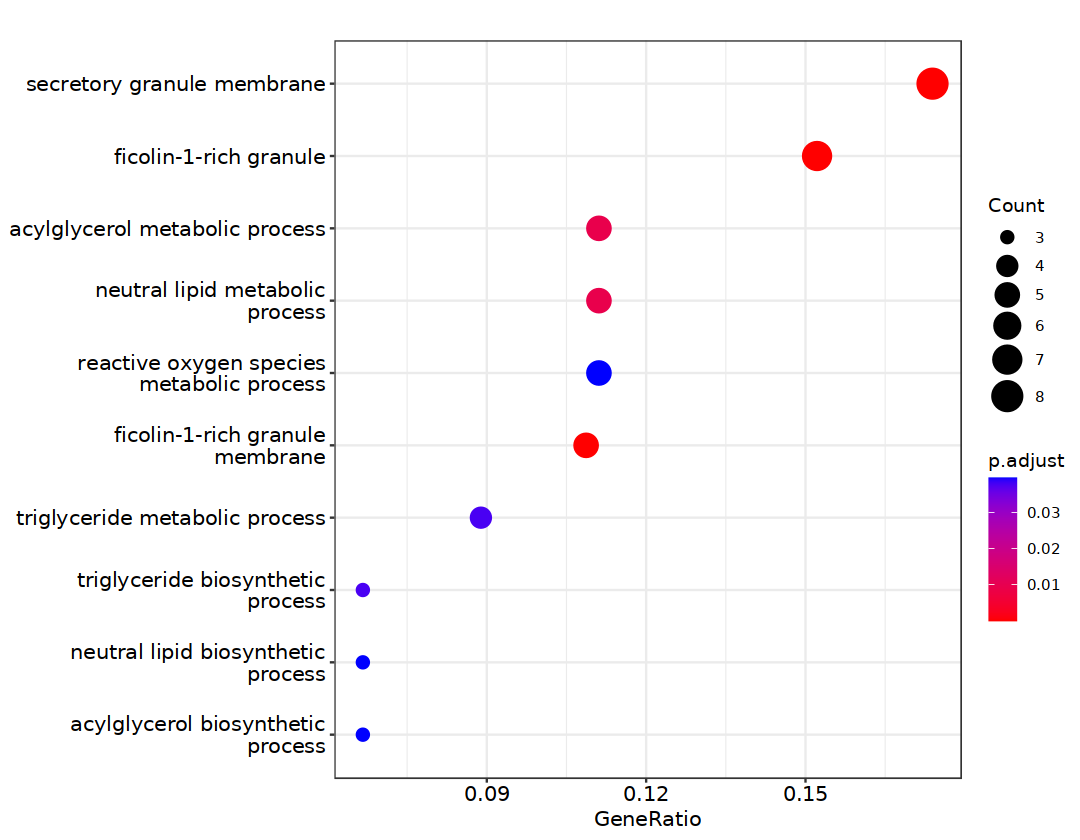

In [45]:
#画图
dotplot(go_bp)

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



ERROR: Error in pairwise_termsim(ek): could not find function "pairwise_termsim"


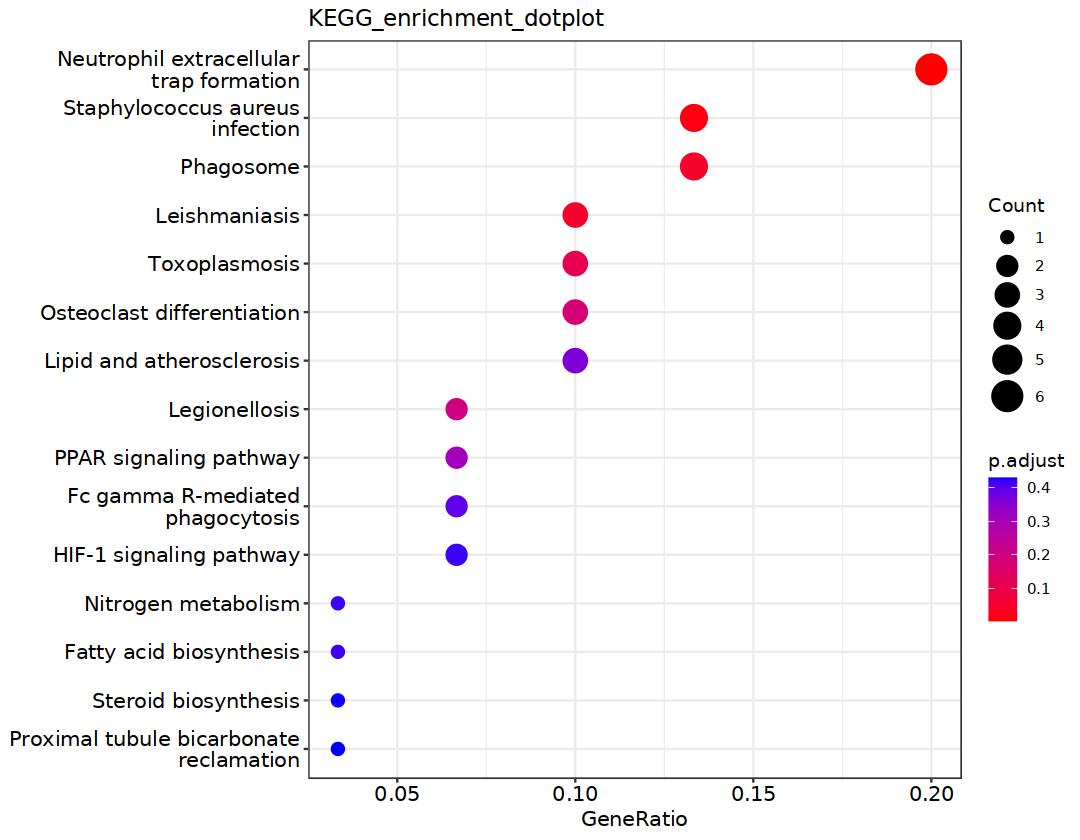

In [46]:
ek <- enrichKEGG(gene =sig_DP_entrezId , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result
    #write.csv(keggres,file = 'kegg_results.csv')
    enrichplot::dotplot(ek,  
            x = "GeneRatio", 
            color = "p.adjust", 
            showCategory = 15, 
            size = 'Count', 
            title = "KEGG_enrichment_dotplot"  
            )
    #ggsave('KEGG_enrichment_dotplot.pdf',height = 6,width = 6)
    KEGG2 <- pairwise_termsim(ek)
    emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
      ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
    #ggsave('KEGG_enrichment_net.pdf',height = 8,width = 8)   